## RISE IMPLEMENTATION

In [18]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K
from keras.preprocessing import image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import cv2
from PIL import Image
from matplotlib import cm
import sys
import os
import tensorflow as tf
from platform import python_version 



import matplotlib.pyplot as plt
from skimage.transform import resize   
%matplotlib inline

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

In [19]:

IMG_HEIGHT = 224  
IMG_WIDTH = 224  

f_restnet = ResNet50(weights='imagenet', input_shape=(224,224,3)) 


f_restnet.summary() 

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Create Mask

In [32]:
def create_mask():
    #1: Set the varible for number of masks, size of grid and proabaility of grid pixel being 1
    N = 1000 # set numer of binary masks
    s = 8   # set the size of the mask value for h & w 
    pl = 0.5  # set probability of each element from in the mask being a one

    #2. Create N grids of size s x s containing random 0's and 1's with equal proability.
    grid = np.random.rand(N, s, s)

    #3. Print the shape of the 3D array generated.
    #print("Size of grid array: ", grid.shape)

    unique, counts = np.unique(grid, return_counts=True)
    p =  counts[1] / sum(counts)
    #print("probability of ones acieved = ",p)

    #print(grid[0].shape) 
    plt.gray()
    plt.imshow((grid[2]))

    grid = grid.astype('float32')

    M_i = np.empty([N, 224, 224])

    #2. Print size of array
    #print("masks shape", M_i.shape)

    # Calculate cell size
    cell_size = np.ceil(np.array((IMG_HEIGHT,IMG_WIDTH)) / s)
    up_size = (s + 1) * cell_size

    for i in range(N):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        M_i[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect', anti_aliasing=True)[x:x + IMG_HEIGHT, y:y + IMG_WIDTH]

    #print (M_i[0].shape)

    M_i = M_i.reshape(-1, IMG_HEIGHT,IMG_WIDTH, 1)

    #1. Print shape of M_i
    #print("shape of  M_i ", M_i.shape)

    return (M_i)

## Mask the input tensor image

In [24]:
def mask_tensor(M_i, input_image_tensor):
    #2: pixelwise multiplication the masks and the input image 
    masked = M_i * input_image_tensor
    test_image = masked[10]
    print("Masked Image")
    plt.imshow(np.uint8(test_image))
    plt.show()
    test_image = np.expand_dims(test_image, axis=0)

    

    #Run Classifier on Masked Image
    pred_test_image = f_restnet.predict(test_image)
    masked_image_labels = decode_predictions(pred_test_image)

    print ("Top 5 Labels for Masked Image = ", masked_image_labels)


    batch_size = 100

    preds = []
    # Make sure multiplication is being done for correct axes
    N= 1000
    pl= 0.5
    for i in range(0, N, batch_size):
        preds.append(f_restnet.predict(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)

    sal = preds.T.dot(M_i.reshape(N, -1)).reshape(-1, IMG_HEIGHT,IMG_WIDTH)
    sal = sal / N / pl
    return (sal, pred_test_image )

In [25]:
def class_name(idx):
        return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

# Image 1

ResNet50 Predictions =  [[('n01582220', 'magpie', 0.9883378), ('n01795545', 'black_grouse', 0.0056231464), ('n01601694', 'water_ouzel', 0.0028173693), ('n02037110', 'oystercatcher', 0.00060071185), ('n01798484', 'prairie_chicken', 0.00045846598)]]
(224, 224)
Masked Image


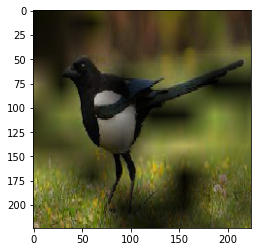

Top 5 Labels for Masked Image =  [[('n01601694', 'water_ouzel', 0.54308176), ('n01582220', 'magpie', 0.3135075), ('n02058221', 'albatross', 0.022319585), ('n02037110', 'oystercatcher', 0.01974641), ('n01944390', 'snail', 0.015476493)]]
Classification confidence for class magpie is:  [0.3135075]


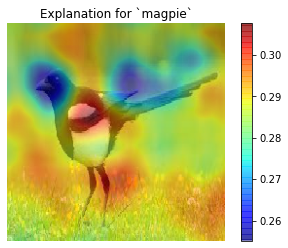

Wall time: 2min 6s


In [28]:
%%time
filename = 'C:/Users/BM/Desktop/LIME&RISE/magpie.jfif'
original_image = image.load_img(filename) 
resize_image = original_image.resize((IMG_HEIGHT, IMG_WIDTH), resample=0)
numpy_image = image.img_to_array(resize_image) 
input_image_tensor = np.expand_dims(numpy_image, axis=0)
processed_image = preprocess_input(input_image_tensor.copy())     
#print("Processed Input tensor size and shape = ", processed_image.shape)

# Predict ojects using ResNet50 and List the top 5 labels
predictions_resnet50 = f_restnet.predict(processed_image)
label_resnet50 = decode_predictions(predictions_resnet50)

print ("ResNet50 Predictions = ", label_resnet50)

M_i = create_mask()
sal, pred_test_image = mask_tensor(M_i, input_image_tensor)

class_label = 18
print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,18])

#change class label code
class_idx = 18
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()



# Image 2

ResNet50 Predictions =  [[('n03125729', 'cradle', 0.537463), ('n02804414', 'bassinet', 0.45932558), ('n03131574', 'crib', 0.0030452241), ('n04204238', 'shopping_basket', 6.7131885e-05), ('n03482405', 'hamper', 5.9513743e-05)]]
(224, 224)
Masked Image


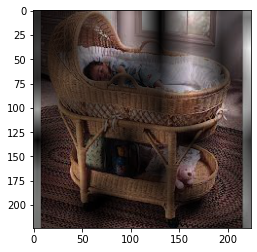

Top 5 Labels for Masked Image =  [[('n02804414', 'bassinet', 0.93524575), ('n03125729', 'cradle', 0.020835074), ('n03788365', 'mosquito_net', 0.012496127), ('n03131574', 'crib', 0.011434112), ('n04099969', 'rocking_chair', 0.0033726434)]]
Classification confidence for class bassinet is:  [0.93524575]


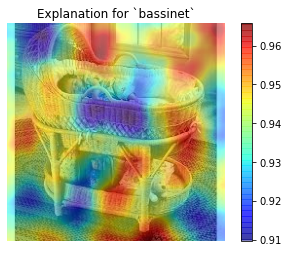

In [30]:
filename = 'C:/Users/BM/Desktop/LIME&RISE/bassinet.jfif'
original_image = image.load_img(filename) 
resize_image = original_image.resize((IMG_HEIGHT, IMG_WIDTH), resample=0)
numpy_image = image.img_to_array(resize_image) 
input_image_tensor = np.expand_dims(numpy_image, axis=0)
processed_image = preprocess_input(input_image_tensor.copy())     


# Predict ojects using ResNet50 and List the top 5 labels
predictions_resnet50 = f_restnet.predict(processed_image)
label_resnet50 = decode_predictions(predictions_resnet50)

print ("ResNet50 Predictions = ", label_resnet50)

M_i = create_mask()
sal, pred_test_image = mask_tensor(M_i, input_image_tensor)

class_label = 431
print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,431])

#change class label code
class_idx = 431
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()




# Image 3

ResNet50 Predictions =  [[('n02843684', 'birdhouse', 0.9994824), ('n03710193', 'mailbox', 0.00021787874), ('n04258138', 'solar_dish', 4.7491187e-05), ('n03930313', 'picket_fence', 3.7312326e-05), ('n03976657', 'pole', 3.0162228e-05)]]
(224, 224)
Masked Image


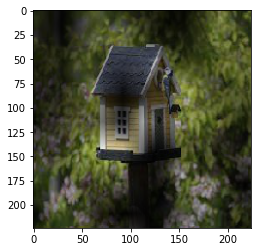

Top 5 Labels for Masked Image =  [[('n02843684', 'birdhouse', 0.9949935), ('n01537544', 'indigo_bunting', 0.0033192441), ('n04589890', 'window_screen', 0.0003029598), ('n01580077', 'jay', 0.00018400622), ('n03930313', 'picket_fence', 0.000123181)]]
Classification confidence for class birdhouse is:  [0.9949935]


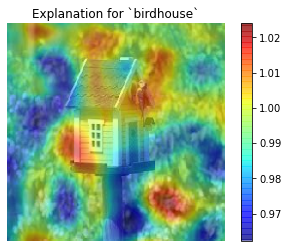

In [31]:
filename = 'C:/Users/BM/Desktop/LIME&RISE/birdhouse.jfif'
original_image = image.load_img(filename) 
resize_image = original_image.resize((IMG_HEIGHT, IMG_WIDTH), resample=0)
numpy_image = image.img_to_array(resize_image) 
input_image_tensor = np.expand_dims(numpy_image, axis=0)
processed_image = preprocess_input(input_image_tensor.copy())     


# Predict ojects using ResNet50 and List the top 5 labels
predictions_resnet50 = f_restnet.predict(processed_image)
label_resnet50 = decode_predictions(predictions_resnet50)

print ("ResNet50 Predictions = ", label_resnet50)

M_i = create_mask()
sal, pred_test_image = mask_tensor(M_i, input_image_tensor)

class_label = 448
print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,448])

#change class label code
class_idx = 448
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()



# Image 4

ResNet50 Predictions =  [[('n02106166', 'Border_collie', 0.30674076), ('n02090622', 'borzoi', 0.2902372), ('n02105056', 'groenendael', 0.22047381), ('n02106030', 'collie', 0.14271301), ('n02091831', 'Saluki', 0.00765491)]]
Masked Image


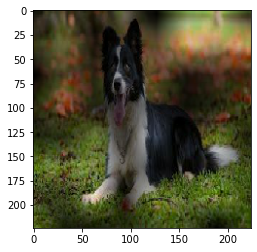

Top 5 Labels for Masked Image =  [[('n02088094', 'Afghan_hound', 0.59225696), ('n02105251', 'briard', 0.14366187), ('n02109047', 'Great_Dane', 0.09162244), ('n02090721', 'Irish_wolfhound', 0.059696555), ('n02091134', 'whippet', 0.022469305)]]
Classification confidence for class Border_collie is:  [0.0010979]


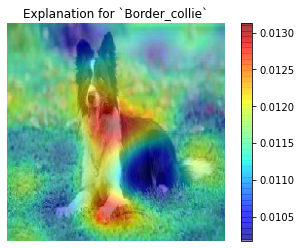

In [33]:
filename = 'C:/Users/BM/Desktop/LIME&RISE/bordercollie.jfif'
original_image = image.load_img(filename) 
resize_image = original_image.resize((IMG_HEIGHT, IMG_WIDTH), resample=0)
numpy_image = image.img_to_array(resize_image) 
input_image_tensor = np.expand_dims(numpy_image, axis=0)
processed_image = preprocess_input(input_image_tensor.copy())     


# Predict ojects using ResNet50 and List the top 5 labels
predictions_resnet50 = f_restnet.predict(processed_image)
label_resnet50 = decode_predictions(predictions_resnet50)

print ("ResNet50 Predictions = ", label_resnet50)

M_i = create_mask()
sal, pred_test_image = mask_tensor(M_i, input_image_tensor)

class_label = 232
print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,232])

#change class label code
class_idx = 232
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()



# Image 5

ResNet50 Predictions =  [[('n02099429', 'curly-coated_retriever', 0.735014), ('n02102973', 'Irish_water_spaniel', 0.14566365), ('n02099849', 'Chesapeake_Bay_retriever', 0.08178505), ('n02100877', 'Irish_setter', 0.012921173), ('n02102480', 'Sussex_spaniel', 0.008970718)]]
Masked Image


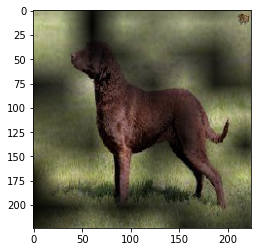

Top 5 Labels for Masked Image =  [[('n02099429', 'curly-coated_retriever', 0.34032488), ('n02099849', 'Chesapeake_Bay_retriever', 0.1502719), ('n02104029', 'kuvasz', 0.056395892), ('n02102973', 'Irish_water_spaniel', 0.044503056), ('n02105412', 'kelpie', 0.038511872)]]
Classification confidence for class Chesapeake_Bay_retriever is:  [0.1502719]


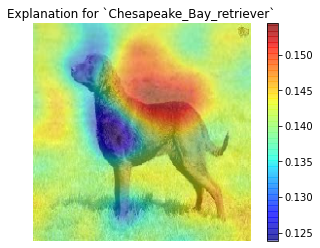

In [34]:
filename = 'C:/Users/BM/Desktop/LIME&RISE/ChesapeakeBayretriever.jfif'
original_image = image.load_img(filename) 
resize_image = original_image.resize((IMG_HEIGHT, IMG_WIDTH), resample=0)
numpy_image = image.img_to_array(resize_image) 
input_image_tensor = np.expand_dims(numpy_image, axis=0)
processed_image = preprocess_input(input_image_tensor.copy())     


# Predict ojects using ResNet50 and List the top 5 labels
predictions_resnet50 = f_restnet.predict(processed_image)
label_resnet50 = decode_predictions(predictions_resnet50)

print ("ResNet50 Predictions = ", label_resnet50)

M_i = create_mask()
sal, pred_test_image = mask_tensor(M_i, input_image_tensor)

class_label = 209
print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,209])

#change class label code
class_idx = 209
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()



# Image 6

ResNet50 Predictions =  [[('n03045698', 'cloak', 0.99975127), ('n02667093', 'abaya', 0.00020772874), ('n03866082', 'overskirt', 3.1110925e-05), ('n03450230', 'gown', 2.3227312e-06), ('n04532106', 'vestment', 1.8028414e-06)]]
Masked Image


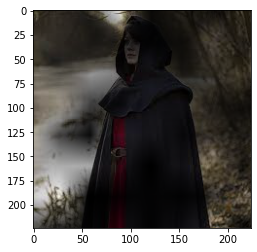

Top 5 Labels for Masked Image =  [[('n03045698', 'cloak', 0.9995603), ('n02667093', 'abaya', 0.00030278208), ('n03450230', 'gown', 8.8692366e-05), ('n03866082', 'overskirt', 2.6267042e-05), ('n04532106', 'vestment', 8.527449e-06)]]
Classification confidence for class cloak is:  [0.9995603]


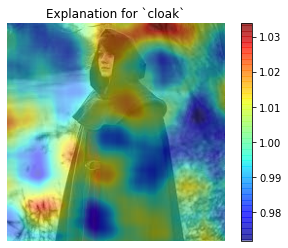

In [35]:
filename = 'C:/Users/BM/Desktop/LIME&RISE/cloak.jfif'
original_image = image.load_img(filename) 
resize_image = original_image.resize((IMG_HEIGHT, IMG_WIDTH), resample=0)
numpy_image = image.img_to_array(resize_image) 
input_image_tensor = np.expand_dims(numpy_image, axis=0)
processed_image = preprocess_input(input_image_tensor.copy())     


# Predict ojects using ResNet50 and List the top 5 labels
predictions_resnet50 = f_restnet.predict(processed_image)
label_resnet50 = decode_predictions(predictions_resnet50)

print ("ResNet50 Predictions = ", label_resnet50)

M_i = create_mask()
sal, pred_test_image = mask_tensor(M_i, input_image_tensor)

class_label = 501
print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,501])

#change class label code
class_idx = 501
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()



# Image 7

ResNet50 Predictions =  [[('n03617480', 'kimono', 0.99978787), ('n04532106', 'vestment', 0.00012839011), ('n03877472', 'pajama', 5.1090024e-05), ('n02667093', 'abaya', 2.3956927e-05), ('n02669723', 'academic_gown', 1.98896e-06)]]
Masked Image


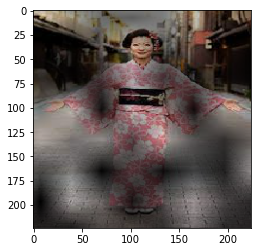

Top 5 Labels for Masked Image =  [[('n03146219', 'cuirass', 0.4609797), ('n02895154', 'breastplate', 0.3863833), ('n04522168', 'vase', 0.06356713), ('n04192698', 'shield', 0.008564615), ('n04553703', 'washbasin', 0.0069000646)]]
Classification confidence for class kimono is:  [0.00429266]


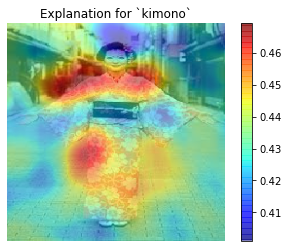

In [36]:
filename = 'C:/Users/BM/Desktop/LIME&RISE/kimono.jfif'
original_image = image.load_img(filename) 
resize_image = original_image.resize((IMG_HEIGHT, IMG_WIDTH), resample=0)
numpy_image = image.img_to_array(resize_image) 
input_image_tensor = np.expand_dims(numpy_image, axis=0)
processed_image = preprocess_input(input_image_tensor.copy())     


# Predict ojects using ResNet50 and List the top 5 labels
predictions_resnet50 = f_restnet.predict(processed_image)
label_resnet50 = decode_predictions(predictions_resnet50)

print ("ResNet50 Predictions = ", label_resnet50)

M_i = create_mask()
sal, pred_test_image = mask_tensor(M_i, input_image_tensor)

class_label = 614
print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,614])

#change class label code
class_idx = 614
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()



# Image 8

ResNet50 Predictions =  [[('n03877845', 'palace', 0.9882869), ('n03781244', 'monastery', 0.0065847347), ('n04005630', 'prison', 0.0036502716), ('n04523525', 'vault', 0.0009962703), ('n02980441', 'castle', 0.00017099318)]]
Masked Image


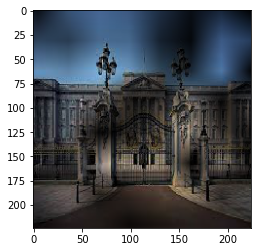

Top 5 Labels for Masked Image =  [[('n03877845', 'palace', 0.9780216), ('n03781244', 'monastery', 0.004789329), ('n04523525', 'vault', 0.0045521455), ('n04005630', 'prison', 0.0026276542), ('n03388043', 'fountain', 0.002292871)]]
Classification confidence for class palace is:  [0.9780216]


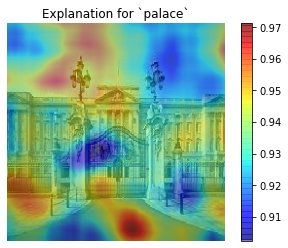

In [37]:
filename = 'C:/Users/BM/Desktop/LIME&RISE/palace.jfif'
original_image = image.load_img(filename) 
resize_image = original_image.resize((IMG_HEIGHT, IMG_WIDTH), resample=0)
numpy_image = image.img_to_array(resize_image) 
input_image_tensor = np.expand_dims(numpy_image, axis=0)
processed_image = preprocess_input(input_image_tensor.copy())     


# Predict ojects using ResNet50 and List the top 5 labels
predictions_resnet50 = f_restnet.predict(processed_image)
label_resnet50 = decode_predictions(predictions_resnet50)

print ("ResNet50 Predictions = ", label_resnet50)

M_i = create_mask()
sal, pred_test_image = mask_tensor(M_i, input_image_tensor)

class_label = 698
print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,698])

#change class label code
class_idx = 698
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()



# Image 9

ResNet50 Predictions =  [[('n01806143', 'peacock', 0.99824333), ('n02319095', 'sea_urchin', 0.001274982), ('n09256479', 'coral_reef', 0.0001121298), ('n01914609', 'sea_anemone', 0.00010413699), ('n04033901', 'quill', 0.000100389596)]]
Masked Image


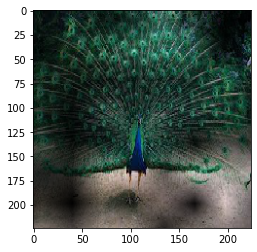

Top 5 Labels for Masked Image =  [[('n03388043', 'fountain', 0.2362268), ('n09256479', 'coral_reef', 0.07111563), ('n04589890', 'window_screen', 0.062898844), ('n02319095', 'sea_urchin', 0.03159751), ('n04507155', 'umbrella', 0.022896234)]]
Classification confidence for class peacock is:  [0.01820716]


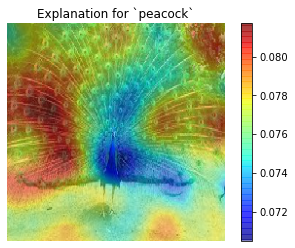

In [38]:
filename = 'C:/Users/BM/Desktop/LIME&RISE/peacock.jfif'
original_image = image.load_img(filename) 
resize_image = original_image.resize((IMG_HEIGHT, IMG_WIDTH), resample=0)
numpy_image = image.img_to_array(resize_image) 
input_image_tensor = np.expand_dims(numpy_image, axis=0)
processed_image = preprocess_input(input_image_tensor.copy())     


# Predict ojects using ResNet50 and List the top 5 labels
predictions_resnet50 = f_restnet.predict(processed_image)
label_resnet50 = decode_predictions(predictions_resnet50)

print ("ResNet50 Predictions = ", label_resnet50)

M_i = create_mask()
sal, pred_test_image = mask_tensor(M_i, input_image_tensor)

class_label = 84
print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,84])

#change class label code
class_idx = 84
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()



# Image 10

ResNet50 Predictions =  [[('n04090263', 'rifle', 0.92484903), ('n02749479', 'assault_rifle', 0.074844114), ('n04086273', 'revolver', 0.00027679594), ('n04536866', 'violin', 1.3146477e-05), ('n02879718', 'bow', 1.1639049e-05)]]
Masked Image


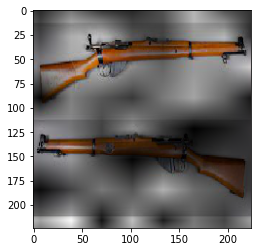

Top 5 Labels for Masked Image =  [[('n03126707', 'crane', 0.78732514), ('n02692877', 'airship', 0.047003355), ('n02268853', 'damselfly', 0.043749023), ('n02879718', 'bow', 0.015075933), ('n04228054', 'ski', 0.009405711)]]
Classification confidence for class rifle is:  [0.00324253]


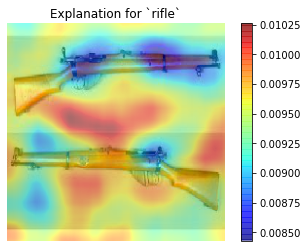

In [39]:
filename = 'C:/Users/BM/Desktop/LIME&RISE/rifle.jfif'
original_image = image.load_img(filename) 
resize_image = original_image.resize((IMG_HEIGHT, IMG_WIDTH), resample=0)
numpy_image = image.img_to_array(resize_image) 
input_image_tensor = np.expand_dims(numpy_image, axis=0)
processed_image = preprocess_input(input_image_tensor.copy())     


# Predict ojects using ResNet50 and List the top 5 labels
predictions_resnet50 = f_restnet.predict(processed_image)
label_resnet50 = decode_predictions(predictions_resnet50)

print ("ResNet50 Predictions = ", label_resnet50)

M_i = create_mask()
sal, pred_test_image = mask_tensor(M_i, input_image_tensor)

class_label = 764
print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,764])

#change class label code
class_idx = 764
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()



# Image 11

ResNet50 Predictions =  [[('n04285008', 'sports_car', 0.58094215), ('n04037443', 'racer', 0.41073436), ('n02974003', 'car_wheel', 0.0039789546), ('n03930630', 'pickup', 0.0021205836), ('n03100240', 'convertible', 0.0009066125)]]
Masked Image


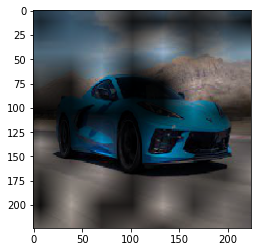

Top 5 Labels for Masked Image =  [[('n02930766', 'cab', 0.5801822), ('n04285008', 'sports_car', 0.20026863), ('n04037443', 'racer', 0.19494776), ('n03100240', 'convertible', 0.0057662046), ('n04252077', 'snowmobile', 0.004088442)]]
Classification confidence for class sports_car is:  [0.20026863]


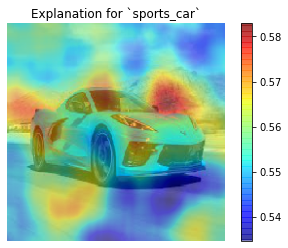

In [40]:
filename = 'C:/Users/BM/Desktop/LIME&RISE/sportscar.jfif'
original_image = image.load_img(filename) 
resize_image = original_image.resize((IMG_HEIGHT, IMG_WIDTH), resample=0)
numpy_image = image.img_to_array(resize_image) 
input_image_tensor = np.expand_dims(numpy_image, axis=0)
processed_image = preprocess_input(input_image_tensor.copy())     


# Predict ojects using ResNet50 and List the top 5 labels
predictions_resnet50 = f_restnet.predict(processed_image)
label_resnet50 = decode_predictions(predictions_resnet50)

print ("ResNet50 Predictions = ", label_resnet50)

M_i = create_mask()
sal, pred_test_image = mask_tensor(M_i, input_image_tensor)

class_label = 817
print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,817])

#change class label code
class_idx = 817
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()



# Image 12

ResNet50 Predictions =  [[('n01498041', 'stingray', 0.611519), ('n01496331', 'electric_ray', 0.38815615), ('n02074367', 'dugong', 0.00014269615), ('n01491361', 'tiger_shark', 4.4255572e-05), ('n02066245', 'grey_whale', 2.0837753e-05)]]
Masked Image


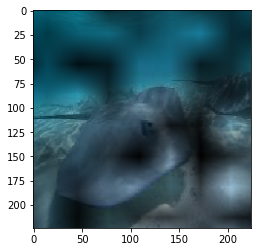

Top 5 Labels for Masked Image =  [[('n03388043', 'fountain', 0.17387562), ('n11879895', 'rapeseed', 0.08957198), ('n04228054', 'ski', 0.054745745), ('n09288635', 'geyser', 0.04101389), ('n01795545', 'black_grouse', 0.039196387)]]
Classification confidence for class stingray is:  [5.7045086e-06]


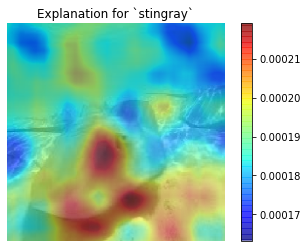

In [41]:
filename = 'C:/Users/BM/Desktop/LIME&RISE/stingray.jfif'
original_image = image.load_img(filename) 
resize_image = original_image.resize((IMG_HEIGHT, IMG_WIDTH), resample=0)
numpy_image = image.img_to_array(resize_image) 
input_image_tensor = np.expand_dims(numpy_image, axis=0)
processed_image = preprocess_input(input_image_tensor.copy())     


# Predict ojects using ResNet50 and List the top 5 labels
predictions_resnet50 = f_restnet.predict(processed_image)
label_resnet50 = decode_predictions(predictions_resnet50)

print ("ResNet50 Predictions = ", label_resnet50)

M_i = create_mask()
sal, pred_test_image = mask_tensor(M_i, input_image_tensor)

class_label = 6
print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,6])

#change class label code
class_idx = 6
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()



# Image 13

ResNet50 Predictions =  [[('n01774750', 'tarantula', 0.9728071), ('n01773549', 'barn_spider', 0.020396952), ('n01776313', 'tick', 0.0021363664), ('n01980166', 'fiddler_crab', 0.0010445792), ('n01773797', 'garden_spider', 0.00062608323)]]
Masked Image


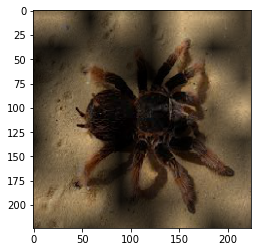

Top 5 Labels for Masked Image =  [[('n01774750', 'tarantula', 0.8306435), ('n01776313', 'tick', 0.08024286), ('n01773549', 'barn_spider', 0.055570357), ('n01775062', 'wolf_spider', 0.02074731), ('n01978455', 'rock_crab', 0.0037249424)]]
Classification confidence for class tarantula is:  [0.8306435]


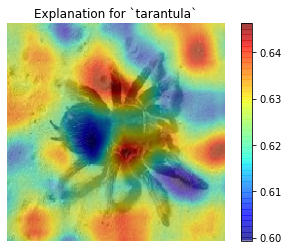

In [42]:
filename = 'C:/Users/BM/Desktop/LIME&RISE/tarantula.jfif'
original_image = image.load_img(filename) 
resize_image = original_image.resize((IMG_HEIGHT, IMG_WIDTH), resample=0)
numpy_image = image.img_to_array(resize_image) 
input_image_tensor = np.expand_dims(numpy_image, axis=0)
processed_image = preprocess_input(input_image_tensor.copy())     


# Predict ojects using ResNet50 and List the top 5 labels
predictions_resnet50 = f_restnet.predict(processed_image)
label_resnet50 = decode_predictions(predictions_resnet50)

print ("ResNet50 Predictions = ", label_resnet50)

M_i = create_mask()
sal, pred_test_image = mask_tensor(M_i, input_image_tensor)

class_label = 76
print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,76])

#change class label code
class_idx = 76
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()



# Image 14

ResNet50 Predictions =  [[('n01843383', 'toucan', 0.97728854), ('n01829413', 'hornbill', 0.014705787), ('n01798484', 'prairie_chicken', 0.0013915042), ('n01807496', 'partridge', 0.0012139196), ('n02017213', 'European_gallinule', 0.0009542195)]]
Masked Image


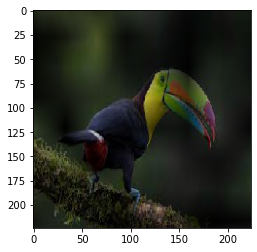

Top 5 Labels for Masked Image =  [[('n01843383', 'toucan', 0.47681227), ('n01770393', 'scorpion', 0.0850878), ('n02017213', 'European_gallinule', 0.037376948), ('n09229709', 'bubble', 0.033259), ('n02777292', 'balance_beam', 0.018919393)]]
Classification confidence for class toucan is:  [0.47681227]


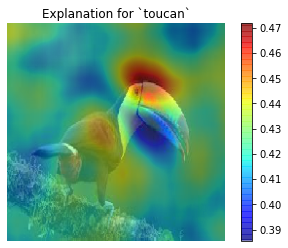

In [43]:
filename = 'C:/Users/BM/Desktop/LIME&RISE/toucan.jfif'
original_image = image.load_img(filename) 
resize_image = original_image.resize((IMG_HEIGHT, IMG_WIDTH), resample=0)
numpy_image = image.img_to_array(resize_image) 
input_image_tensor = np.expand_dims(numpy_image, axis=0)
processed_image = preprocess_input(input_image_tensor.copy())     


# Predict ojects using ResNet50 and List the top 5 labels
predictions_resnet50 = f_restnet.predict(processed_image)
label_resnet50 = decode_predictions(predictions_resnet50)

print ("ResNet50 Predictions = ", label_resnet50)

M_i = create_mask()
sal, pred_test_image = mask_tensor(M_i, input_image_tensor)

class_label = 96
print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,96])

#change class label code
class_idx = 96
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()



# Image 15

ResNet50 Predictions =  [[('n04442312', 'toaster', 0.9999999), ('n04372370', 'switch', 2.9863187e-08), ('n03666591', 'lighter', 2.5326823e-08), ('n03908714', 'pencil_sharpener', 1.6455319e-08), ('n04041544', 'radio', 1.3152221e-08)]]
Masked Image


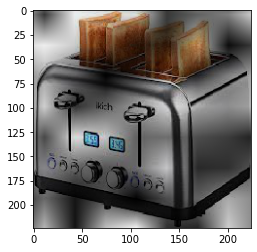

Top 5 Labels for Masked Image =  [[('n04442312', 'toaster', 0.9942642), ('n03297495', 'espresso_maker', 0.0017492959), ('n04372370', 'switch', 0.0013068015), ('n04330267', 'stove', 0.0005755081), ('n04070727', 'refrigerator', 0.00021456185)]]
Classification confidence for class toaster is:  [0.9942642]


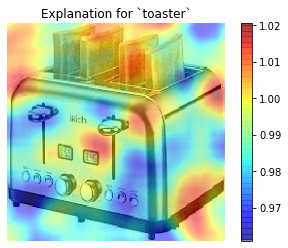

In [44]:
filename = 'C:/Users/BM/Desktop/LIME&RISE/toaster.jfif'
original_image = image.load_img(filename) 
resize_image = original_image.resize((IMG_HEIGHT, IMG_WIDTH), resample=0)
numpy_image = image.img_to_array(resize_image) 
input_image_tensor = np.expand_dims(numpy_image, axis=0)
processed_image = preprocess_input(input_image_tensor.copy())     


# Predict ojects using ResNet50 and List the top 5 labels
predictions_resnet50 = f_restnet.predict(processed_image)
label_resnet50 = decode_predictions(predictions_resnet50)

print ("ResNet50 Predictions = ", label_resnet50)

M_i = create_mask()
sal, pred_test_image = mask_tensor(M_i, input_image_tensor)

class_label = 859
print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,859])

#change class label code
class_idx = 859
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

